In [17]:


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# IMPLEMENTASI DATA MINING PADA ANALISIS KEAMANAN ALGORITMA ENKRIPSI CAESAR CIPHER
## Penulis: Bagas Rayhan Sebastian - A11.2022.14715

# Latar Belakang Masalah
Kriptanalisis adalah metode untuk mengetahui kelemahan dari suatu algoritma kriptografi. Kriptanalisis berkerja dengan cara persamaan matematis seperti analisa frekuensi dan analisa pola untuk menebak kunci sehingga didapatkan pesan asli (plaintext) dari kalimat terenkripsi (cipher text). Metode ini umum digunakan untuk mencari celah keamanan pada berbagai algoritma kriptografi, seperti Caesar Cipher (Uci Julya Ningsih, 2024).

# Bagaimana Regresi Logistik Digunakan Dalam Kriptanalisis
Caesar Cipher adalah algoritma kriptografi yang berkerja dengan cara menggeser setiap karakter sejauh k, misal karakter A digeser menjadi D. Caesar cipher memiliki persamaan matematis sebagai berikut:
`Ci = (Pi + K) mod26`.

Regresi Logistik adalah algoritma yang sering digunakan untuk melakukan klasifikasi. Regresi Logistik menghitung nilai input ke dalam fungsi logit menjadi probabilitas dengan range 0-1.
$$ f(x) = \frac{1}{1 + e^{-x}} $$
Fitur input pada regresi logistik memiliki hubungan yang saling linier dan membentuk fungsi linier `g(x)`, yang dapat dihitung dengan persamaan likelihood sebanyak n iterasi. Penentuan jumlah iterasi yang tepat sangat berpengaruh pada akurasi dan mencegah underfitting atau overfitting.

Implementasi datamining pada kriptanalisis, seperti regresi logistik disebut sebagai cryptic mining (Shaligram Prajapat, 2024). Cryptic mining dapat digunakan untuk klasifikasi, klasterisasi, dll, pada sistem kriptografi.
Dalam cryptic mining, regresi logistik dapat melakukan klasifikasi kunci berdasarkan pola ciphertext.
![bagan](/content/drive/MyDrive/KULIAH/smt-5/datamining/uas/qnlmytkfwynknhnfqnsyjqqnljshj.png)


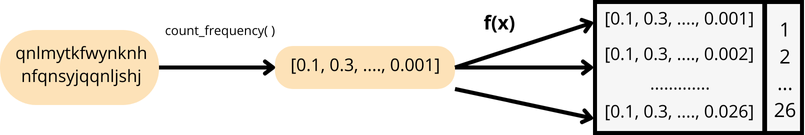

# Dataset dan Exploratory Data Analysis
## Menyiapkan Dataset
Dataset yang disiapkan adalah paragraf berbahasa Inggris sebanyak 61 baris, yang telah dibersihkan sehingga hanya menyisakan karakter alfabetik. Pada berikutnya dataset akan disebut sebagai tabel

In [18]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.linear_model import LogisticRegression
dataset = pd.read_csv('/content/drive/MyDrive/KULIAH/smt-5/datamining/uas/word.csv')
dataset['word'] = dataset['word'].str.lower()
dataset.head()


,word
0,thequickbrownfoxjumpsoverthebusydogsoftlyalway...
1,theenergeticcatjumpedoverthelazyfoxquietlyever...
2,brightsunnymorningsmakemehappyandjoyfulmostoft...
3,learningnewthingskeepsyourmindsharpandactiveev...
4,readingbooksbroadensourhorizonsandexpandsknowl...


In [32]:
dataset.shape

(61, 1)

Kedua method dibawah bertujuan untuk mengubah setiap karakter pada sebuah kalimat dengan pergeseran sejauh `k mod26`, dan menghitung kemunculan huruf A-Z pada suatu kalimat

In [20]:
# membuat method untuk mengekstrak fitur dari kalimat
# create shift
shifts = range(26) # shift memiliki range 0 - 25, representasi dari huruf A - Z

# Function to encrypt text with Caesar cipher
def caesar_cipher_encrypt(text, shift):
    text = text.lower()
    result = ""
    for char in text:
        if char.isalpha():
            shifted = chr((ord(char) - ord('a') + shift) % 26 + ord('a'))
            result += shifted
        else:
            result += char
    return result

# Function to extract frequency features
def extract_features(text):
    # a => 3, e => 5
    frequency = Counter(text)

    total = sum(frequency.values())
    features = [frequency.get(chr(i), 0) / total for i in range(ord('a'), ord('z') + 1)]
    # [0.2, 0.4]
    return features

data = []


Setiap baris atau kalimat pada dataset akan dilakukan enkripsi menggunakan algoritma caesar cipher, sehingga memiliki 26 kombinasi. Tabel yang berisi kalimat hasil pergeseran caesar cipher akan dihitung persentase kemunculan hurufnya mulai dari a-z, dan memiliki ukuran 1586 baris. Setiap baris berisi array persentase kemunculan karakter secara berurutan, dari a-z

In [21]:
# extract features
data_word = {}
plains = []
ciphers = []
keys = []
for text in dataset['word']:
    for shift in shifts:
        encrypted = caesar_cipher_encrypt(text, shift)
        features = extract_features(encrypted) #[0.1, 0.2, ...]
        data.append((features, shift))

        plains.append(text)
        ciphers.append(encrypted)
        keys.append(shift)


df = pd.DataFrame(data, columns=['features', 'shift'])
df.head()

,features,shift
0,"[0.046875, 0.03125, 0.03125, 0.015625, 0.0625,...",0
1,"[0.0, 0.046875, 0.03125, 0.03125, 0.015625, 0....",1
2,"[0.078125, 0.0, 0.046875, 0.03125, 0.03125, 0....",2
3,"[0.015625, 0.078125, 0.0, 0.046875, 0.03125, 0...",3
4,"[0.03125, 0.015625, 0.078125, 0.0, 0.046875, 0...",4


In [22]:
df.shape

(1586, 2)

Kemudian setiap elemen pada array dipecah menjadi 26 kolom sebagai representasi dari huruf a-z. Tabel yang berisi 26 kolom persentase huruf dan 1 kolom kunci akan digunakan untuk melatih dan validasi model. Ukuran akhir yang dimiliki tabel adalah 1586 baris x 27 kolom.


In [23]:
features_df = pd.DataFrame(df['features'].tolist(), columns=[f'feature_{i}' for i in range(26)])
df = pd.concat([df, features_df], axis=1)
df = df.drop(columns=['features'])
print(df.head())

   shift  feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      0   0.046875   0.031250   0.031250   0.015625   0.062500   0.031250   
1      1   0.000000   0.046875   0.031250   0.031250   0.015625   0.062500   
2      2   0.078125   0.000000   0.046875   0.031250   0.031250   0.015625   
3      3   0.015625   0.078125   0.000000   0.046875   0.031250   0.031250   
4      4   0.031250   0.015625   0.078125   0.000000   0.046875   0.031250   

   feature_6  feature_7  feature_8  ...  feature_16  feature_17  feature_18  \
0   0.015625   0.031250   0.046875  ...    0.015625    0.046875    0.093750   
1   0.031250   0.015625   0.031250  ...    0.015625    0.015625    0.046875   
2   0.062500   0.031250   0.015625  ...    0.093750    0.015625    0.015625   
3   0.015625   0.062500   0.031250  ...    0.031250    0.093750    0.015625   
4   0.031250   0.015625   0.062500  ...    0.015625    0.031250    0.093750   

   feature_19  feature_20  feature_21  feature_22  featu

## Exploratory Data Analysis
Dasar teori dari analisis frekuensi adalah anggapan bahwa persebaran kemunculan huruf pada suatu bahasa adalah hampir sama. Maka dilakukan pengecekan nilai varians dan simpangan baku dari tabel untuk memeriksa apakah setiap baris cenderung identik.

In [24]:
df.describe()

,shift,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25
count,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,...,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000
mean,12.500000,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,...,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447,0.038447
std,7.502366,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,...,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387,0.042387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.500000,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,...,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027,0.027027
75%,19.000000,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,...,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500
max,25.000000,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,...,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667


In [25]:
df.var()

,0
shift,56.285489
feature_0,0.001797
feature_1,0.001797
feature_2,0.001797
feature_3,0.001797
feature_4,0.001797
feature_5,0.001797
feature_6,0.001797
feature_7,0.001797
feature_8,0.001797


Berdasarkan ouput diatas, didapatkan nilai varians dan simpangan baku sekitar `0.0017` dan `0.04`. Hasil dari uji statistik tersebut menunjukkan bahwa setiap baris pada tabel memiliki kemiripan.




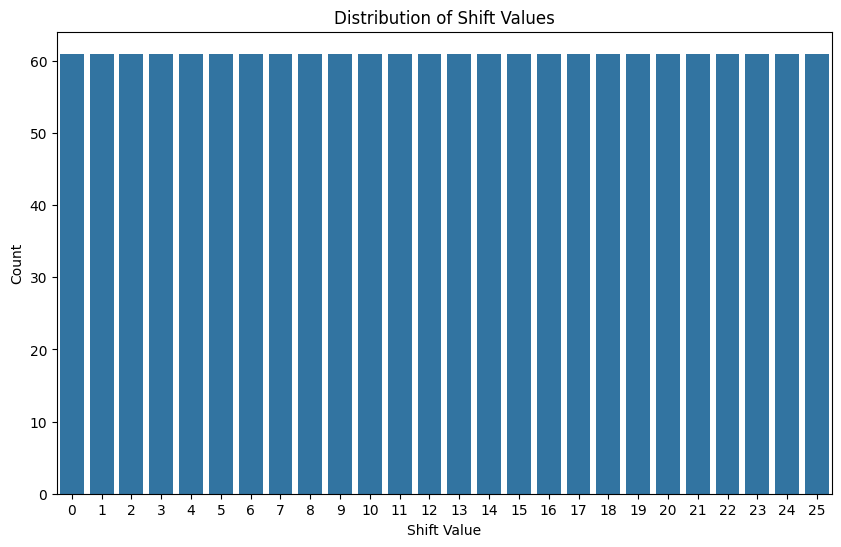

In [33]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='shift', data=df)
plt.title('Distribution of Shift Values')
plt.xlabel('Shift Value')
plt.ylabel('Count')
plt.show()

# Proses Learning Model
Proses pembelajaran menggunakan learning curve dipakai untuk menemukan jumlah iterasi yang paling ideal pada model regresi logistik kriptanalisis.
Pertama akan dibuat model 1 dengan jumlah iterasi sebanyak 10000 kali. Kemudian model tersebut diuji dengan data training dan akan dibuat plot learning curve-nya. Dari plot learning curve tersebut, didapatkan nilai iterasi terbaik dan akan digunakan untuk melatih model kedua. Lalu kedua model tersebut akan diuji untuk memperoleh akurasi terbaik.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

X = df.loc[:, 'feature_0':'feature_25']
y = df['shift']


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_1 = LogisticRegression(max_iter=10000)
model_1.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

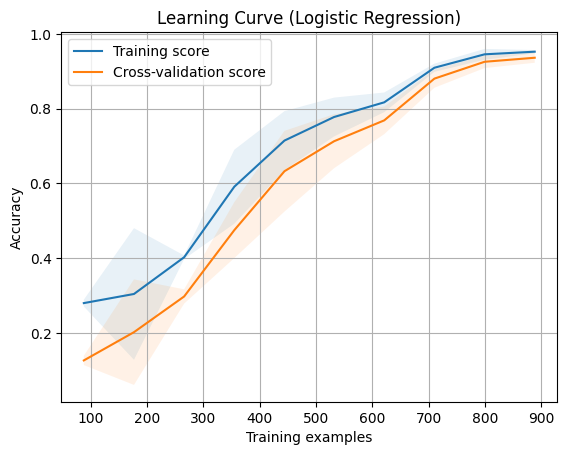

In [28]:

train_sizes, train_scores, test_scores = learning_curve(model_1,
                                                        X_train,
                                                        y_train,
                                                        cv=5, scoring='accuracy',
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation for training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Logistic Regression)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Bagan diatas menampiljan kurva proses pembelajaran model dan cross validation. Kurva pembelajaran dan validasi semakin meningkat dan menyempit seiring banyaknya iterasi, menunjukkan adanya peningkatan performa model. Berdasarkan grafik, maka didapatkan nilai iterasi optimum antara 900 - 1000.

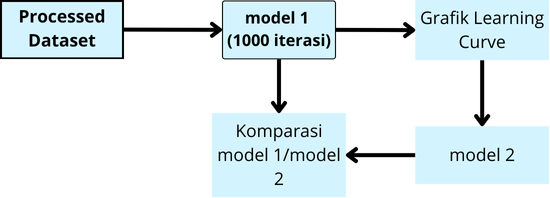

In [36]:
model2 = LogisticRegression(max_iter=900)
model2.fit(X_train, y_train)


LogisticRegression(max_iter=900)

# Evaluasi Performa
Pengukuran kinerja model dalam mengklasifikasikan kunci caesar cipher menggunakan akurasi. Akurasi adalah metriks yang mengukur jumlah prediksi benar valid TP dan prediksi salah valid TN, dibagi dengan jumlah seluruh Kelas. Kedua model akan diukur performa akurasinya dan dibandingkan untuk menentukan mana yang lebih baik, dari sisi performa dan komputasi

In [37]:
y_predict_1 = model_1.predict(X_test)
y_predict_2 = model2.predict(X_test)

score1 = accuracy_score(y_test, y_predict_1)
score2 = accuracy_score(y_test, y_predict_2)
print(f'akurasi model-1: {score1}\t akurasi model-2: {score2}')

akurasi model-1: 0.9264705882352942	 akurasi model-2: 0.9264705882352942


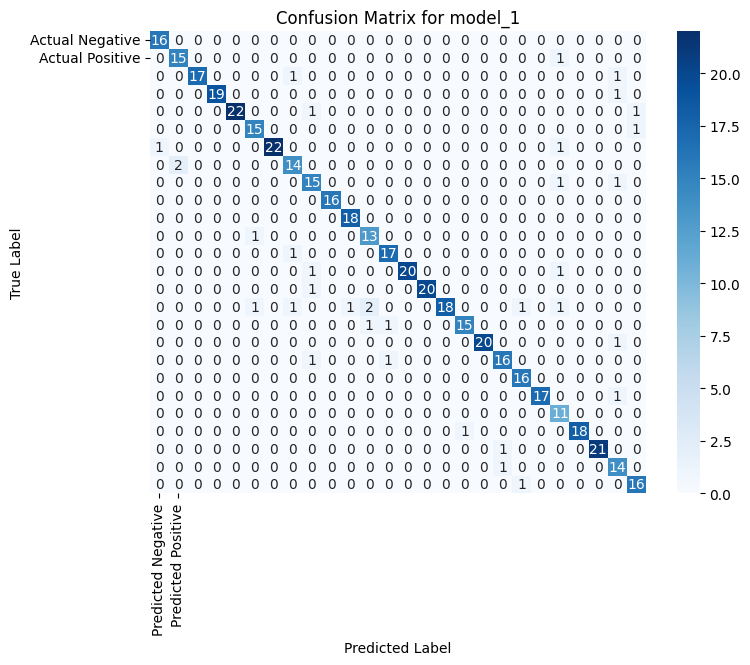

In [38]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_predict_1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix for model_1")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


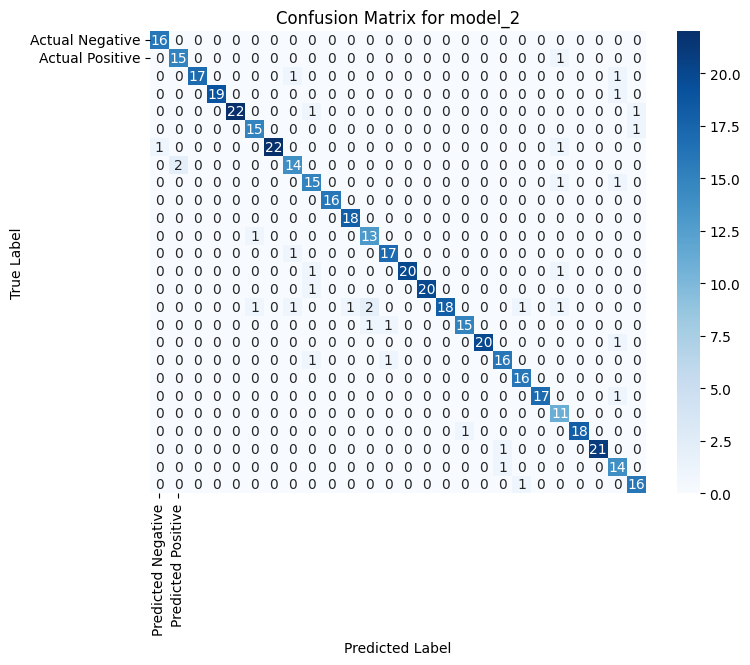

In [39]:


cm2 = confusion_matrix(y_test, y_predict_2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix for model_2")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Pembahasan dan Kesimpulan
Berdasarkan kedua model yang dilatih, akan menghasilkan confussion matriks dengan ukuran 26x26, sehingga persamaan akurasi dari confussion matriks adalah sebagai berikut:


```
             Σ (TP_i + TN_i)
Akurasi =  --------------------- x 100%
           Σ (TP_i + TN_i + FP_i + FN_i)

```

Dari hasil pengukuran sebelumnya, didapat bahwa akurasi kedua model adalah 92,64%. Jika melihat pada grafik, maka ketika memasuki iterasi ke 900 grafik mulai melandai sehingga tidak ada peningkatan yang signifikan, hingga tibalah model mencapai fase stagnan.

Maka dapat disimpulkan bahwa model memiliki iterasi terbaik adalah sekitar 900, karena memiliki memerlukan waktu komputasi yang lebih sedikit.